In [1]:
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-11-10 22:42:43.671515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (9840, 3)
Test Shape: (2109, 3)


In [3]:
def handle_emojis(text):
    return emoji.demojize(str(text), delimiters=(" ", " "))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-zA-Z0-9\u0900-\u097F\s:]", "", text)
    return text.strip()

def preprocess_text(text):
    text = handle_emojis(text)
    text = clean_text(text)
    return text

train_df["Tweet"] = train_df["Tweet"].apply(preprocess_text)
test_df["Tweet"]  = test_df["Tweet"].apply(preprocess_text)

In [4]:
label_encoder = LabelEncoder()
train_df["Label"] = label_encoder.fit_transform(train_df["Label"])
test_df["Label"]  = label_encoder.transform(test_df["Label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'NO': np.int64(0), 'YES': np.int64(1)}


In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["Tweet"], train_df["Label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)

In [6]:
# Tokenization & Padding

MAX_NUM_WORDS = 50000
MAX_SEQ_LEN   = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_val   = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=MAX_SEQ_LEN, padding="post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df["Tweet"]), maxlen=MAX_SEQ_LEN, padding="post")

y_train, y_val, y_test = train_labels.values, val_labels.values, test_df["Label"].values

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (7872, 50) (7872,)
Val: (1968, 50) (1968,)
Test: (2109, 50) (2109,)


In [7]:
embedding_path = "assets/cc.hi.300.vec"
embeddings_index = {}
with open(embedding_path, encoding="utf-8", errors="ignore") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
print("Total Embeddings Loaded:", len(embeddings_index))

word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
print("Embedding Matrix Shape:", embedding_matrix.shape)

Total Embeddings Loaded: 1876654
Embedding Matrix Shape: (22012, 300)


In [8]:
# Model

model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

model.summary()

# Training

early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_bilstm.h5", monitor="val_accuracy",
                             save_best_only=True, mode="max", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

/home/kunj/dau/semester_7/it594_deep_neural_nlp_and_applications/project/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1762794831.248977   73386 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,603,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,603,600 (25.19 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,603,600 (25.19 MB)

Epoch 1/20


2025-11-10 22:43:55.056035: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8741 - loss: 0.3563
Epoch 1: val_accuracy improved from None to 0.93140, saving model to best_bilstm.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9099 - loss: 0.2613 - val_accuracy: 0.9314 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 2/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9401 - loss: 0.1721
Epoch 2: val_accuracy improved from 0.93140 to 0.94665, saving model to best_bilstm.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9395 - loss: 0.1659 - val_accuracy: 0.9466 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 3/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9514 - loss: 0.1392
Epoch 3: val_accuracy did not improve from 0.94665
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9519 - loss: 0.1319 - val_accuracy: 0.9395 - val_loss: 0.1822 - learning_rate: 0.0010
Epoch 4/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9679 - loss: 0.0974
Epoch 4: val_accuracy improved from 0.94665 to 0.94766, saving model to best_bilstm.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9654 - loss: 0.1030 - val_accuracy: 0.9477 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 5/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9694 - loss: 0.0871
Epoch 5: val_accuracy improved from 0.94766 to 0.95122, saving model to best_bilstm.h5


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9732 - loss: 0.0772 - val_accuracy: 0.9512 - val_loss: 0.2154 - learning_rate: 5.0000e-04
Epoch 6/20
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9796 - loss: 0.0604
Epoch 6: val_accuracy did not improve from 0.95122

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9779 - loss: 0.0614 - val_accuracy: 0.9507 - val_loss: 0.2135 - learning_rate: 5.0000e-04


Validation Accuracy: 0.9512, Validation Loss: 0.2154
Test Accuracy: 0.9459, Test Loss: 0.2128
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation Classification Report:
              precision    recall  f1-score   support

          NO       0.91      0.95      0.93       669
         YES       0.98      0.95      0.96      1299

    accuracy                           0.95      1968
   macro avg       0.94      0.95      0.95      1968
weighted avg       0.95      0.95      0.95      1968

Test Classification Report:
              precision    recall  f1-score   support

          NO       0.90      0.94      0.92       706
         YES       0.97      0.95      0.96      1403

    accuracy                           0.95      2109
   macro avg       0.94      0.94      0.94      2109
weighted avg       0.95      0.95      0.95      2109



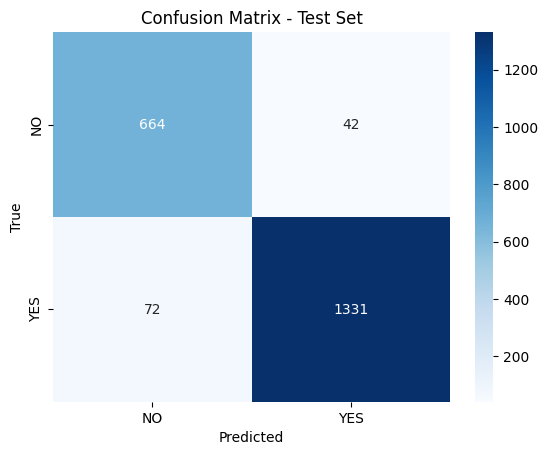

In [9]:
# Evaluation

best_model = load_model("best_bilstm.h5")
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Reports

y_pred_val = (best_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_test = (best_model.predict(X_test) > 0.5).astype(int).flatten()

print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()




Logistic Regression Results
Validation Classification Report (LR):
              precision    recall  f1-score   support

          NO       0.92      0.98      0.95       669
         YES       0.99      0.96      0.97      1299

    accuracy                           0.96      1968
   macro avg       0.96      0.97      0.96      1968
weighted avg       0.97      0.96      0.97      1968

Test Classification Report (LR):
              precision    recall  f1-score   support

          NO       0.93      0.96      0.94       706
         YES       0.98      0.96      0.97      1403

    accuracy                           0.96      2109
   macro avg       0.95      0.96      0.96      2109
weighted avg       0.96      0.96      0.96      2109



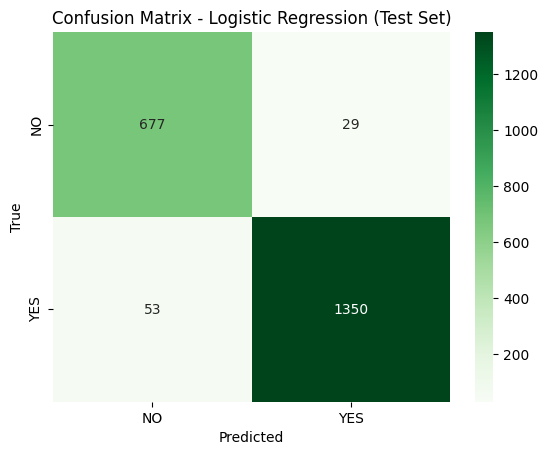

In [10]:
# Baseline Linear Classifier (Logistic Regression with TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF Features
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf   = vectorizer.transform(val_texts)
X_test_tfidf  = vectorizer.transform(test_df["Tweet"])

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_val_pred_lr = log_reg.predict(X_val_tfidf)
y_test_pred_lr = log_reg.predict(X_test_tfidf)

print("\n============================")
print("Logistic Regression Results")
print("============================")
print("Validation Classification Report (LR):")
print(classification_report(y_val, y_val_pred_lr, target_names=label_encoder.classes_))

print("Test Classification Report (LR):")
print(classification_report(y_test, y_test_pred_lr, target_names=label_encoder.classes_))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()



In [11]:
print("Model Comparison")
print("============================")
print(f"BiLSTM Test Accuracy: {test_acc:.4f}")
print(f"Logistic Regression Test Accuracy: {log_reg.score(X_test_tfidf, y_test):.4f}")

if test_acc > log_reg.score(X_test_tfidf, y_test):
    print("BiLSTM outperforms the linear baseline (Logistic Regression).")
else:
    print("Logistic Regression performs comparably or better. Recheck preprocessing/architecture.")

Model Comparison
BiLSTM Test Accuracy: 0.9459
Logistic Regression Test Accuracy: 0.9611
Logistic Regression performs comparably or better. Recheck preprocessing/architecture.



====== Linear SVM Results ======
Validation Classification Report:
              precision    recall  f1-score   support

          NO       0.95      0.97      0.96       669
         YES       0.98      0.98      0.98      1299

    accuracy                           0.97      1968
   macro avg       0.97      0.97      0.97      1968
weighted avg       0.97      0.97      0.97      1968

Test Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.96      0.96       706
         YES       0.98      0.98      0.98      1403

    accuracy                           0.97      2109
   macro avg       0.97      0.97      0.97      2109
weighted avg       0.97      0.97      0.97      2109



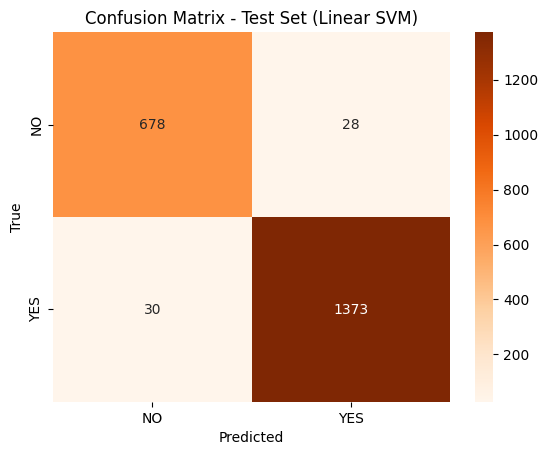


====== Model Comparison ======
BiLSTM Test Accuracy: 0.9459
Linear SVM Test Accuracy: 0.9725


In [12]:
# Baseline Model 2: Linear SVM

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF features
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_texts)
X_val_tfidf   = tfidf.transform(val_texts)
X_test_tfidf  = tfidf.transform(test_df["Tweet"])

# Train Linear SVM
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

# Evaluate
val_preds_svm = svm_clf.predict(X_val_tfidf)
test_preds_svm = svm_clf.predict(X_test_tfidf)

print("\n====== Linear SVM Results ======")
print("Validation Classification Report:")
print(classification_report(y_val, val_preds_svm, target_names=label_encoder.classes_))

print("Test Classification Report:")
print(classification_report(y_test, test_preds_svm, target_names=label_encoder.classes_))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, test_preds_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set (Linear SVM)")
plt.show()

# Final Comparison
print("\n====== Model Comparison ======")
print(f"BiLSTM Test Accuracy: {test_acc:.4f}")
print(f"Linear SVM Test Accuracy: {svm_clf.score(X_test_tfidf, y_test):.4f}")